In [1]:
#import tensorflow as tf
#device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
#  raise SystemError('GPU device not found')
#print('Found GPU at: {}'.format(device_name))

In [2]:
import librosa
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import IPython.display as ipd
import librosa.display
import scipy
import glob
import os
import datetime

# load the tensorboard notebook extension
%load_ext tensorboard

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6627900099887079978,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 18343524659959022346
 physical_device_desc: "device: XLA_CPU device"]

In [4]:
tf.random.set_seed(999)
np.random.seed(999)

In [5]:
path_to_dataset = "/home/abhish/Documents/CED Denoising/Code/records/"

In [6]:
# get training and validation tf record file names
train_tfrecords_filenames = glob.glob(os.path.join(path_to_dataset,'train_*'))
val_tfrecords_filenames = glob.glob(os.path.join(path_to_dataset,'val_*'))

# shuffle the file names for training
np.random.shuffle(train_tfrecords_filenames)
print("Training file names:",train_tfrecords_filenames)
print("Validation file names:", val_tfrecords_filenames)

Training file names: ['/home/abhish/Documents/CED Denoising/Code/records/train_1.tfrecords', '/home/abhish/Documents/CED Denoising/Code/records/train_0.tfrecords', '/home/abhish/Documents/CED Denoising/Code/records/train_2.tfrecords', '/home/abhish/Documents/CED Denoising/Code/records/train_3.tfrecords']
Validation file names: ['/home/abhish/Documents/CED Denoising/Code/records/val_0.tfrecords']


In [7]:
# Parameters about window and audio
windowLength = 256
overlap = round(0.25 * windowLength) #overlap of 75%
fftLength = windowLength
inputFs = 48e3
fs = 16e3
numFeatures = fftLength//2 + 1
numSegments = 8
print("windowLength:",windowLength)
print("overlap:",overlap)
print("ffTLength:",fftLength)
print("inputFs:",inputFs)
print("fs:",fs)
print("numFeatures:",numFeatures)
print("numSegments:",numSegments)

windowLength: 256
overlap: 64
ffTLength: 256
inputFs: 48000.0
fs: 16000.0
numFeatures: 129
numSegments: 8


In [8]:
mozilla_basepath = '/home/abhish/Documents/Dataset/MozillaDataset'
urbansound_basepath = '/home/abhish/Documents/Dataset/UrbanSound8K'

## Prepare Input Features

In [9]:
def tf_record_parser(record):
    keys_to_features = {
        "noise_stft_phase": tf.io.FixedLenFeature((),tf.string,default_value = ""),
        "noise_stft_mag_features": tf.io.FixedLenFeature([],tf.string),
        "clean_stft_magnitude": tf.io.FixedLenFeature((),tf.string)
    }
    
    features = tf.io.parse_single_example(record,keys_to_features)
    
    noise_stft_mag_features = tf.io.decode_raw(features['noise_stft_mag_features'],tf.float32)
    clean_stft_magnitude = tf.io.decode_raw(features['clean_stft_magnitude'],tf.float32)
    noise_stft_phase = tf.io.decode_raw(features['noise_stft_phase'],tf.float32)
    
    # reshape input and annotation images
    noise_stft_mag_features = tf.reshape(noise_stft_mag_features,(129,8,1),name = "noise_stft_mag_features")
    clean_stft_magnitude = tf.reshape(clean_stft_magnitude,(129,1,1),name = "clean_stft_magnitude")
    noise_stft_phase = tf.reshape(noise_stft_phase,(129,),name = "noise_stft_phase")
    
    return noise_stft_mag_features,clean_stft_magnitude

## Create tf.Data.Dataset

In [10]:
train_dataset = tf.data.TFRecordDataset([train_tfrecords_filenames])
train_dataset = train_dataset.map(tf_record_parser)
train_dataset = train_dataset.shuffle(buffer_size = 50)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(32)
train_dataset = train_dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

In [11]:
# explore dataset
print(train_dataset.take(1))

<TakeDataset shapes: ((None, 129, 8, 1), (None, 129, 1, 1)), types: (tf.float32, tf.float32)>


In [12]:
test_dataset = tf.data.TFRecordDataset([val_tfrecords_filenames])
test_dataset = test_dataset.map(tf_record_parser)
test_dataset = test_dataset.repeat(1)
test_dataset = test_dataset.batch(32)

## Model Training

In [13]:
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU, Flatten, Dense, Reshape, Conv2DTranspose, BatchNormalization, Activation
from tensorflow.keras import Model, Sequential

In [14]:
def conv_block(x,filters,kernel_size,strides,padding = 'same',use_bn = True):
    x = Conv2D(filters = filters, 
               kernel_size = kernel_size, 
               strides = strides, 
               padding = padding, 
               use_bias = False,
               kernel_regularizer = tf.keras.regularizers.l2(0.0006)
              )(x)
    
    x = Activation('relu')(x)
    if use_bn:
        x = BatchNormalization()(x)
    return x

In [15]:
def full_pre_activation_block(x,filters,kernel_size,strides,padding='same',use_bn = True):
    shortcut = x
    in_channels = x.shape[-1]
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filter = filters,
               kernel_size = kernel_size,
               strides = strides,
               padding = 'same'
              )(x)
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters = in_channels,
               kernel_size = kernel_size,
               strides = strides,
               padding = 'same'
              )(x)
    
    return shortcut + x

In [16]:
def build_model(l2_strength):
    inputs = Input(shape = [numFeatures,numSegments,1])
    x = inputs
    x = tf.keras.layers.ZeroPadding2D(((4,4),(0,0)))(x)
    
    # 1. -----------------------------------------------------------
    
    x = Conv2D(filters = 18,
              kernel_size = [9,8],
              strides = [1,1],
              padding = 'valid',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    skip0 = Conv2D(filters = 30,
                   kernel_size = [5,1],
                   strides = [1,1],
                   padding = 'same',
                   use_bias = False,
                   kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
                  )(x)
    x = Activation('relu')(skip0)
    x = BatchNormalization()(x)
    
    x = Conv2D(filters = 8,
              kernel_size = [9,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    # 2. ----------------------------------------------------------
    
    x = Conv2D(filters = 18,
              kernel_size = [9,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    skip1 = Conv2D(filters = 30,
                   kernel_size = [5,1],
                   strides = [1,1],
                   padding = 'same',
                   use_bias = False,
                   kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
                  )(x)
    x = Activation('relu')(skip1)
    x = BatchNormalization()(x)
    
    x = Conv2D(filters = 8,
              kernel_size = [9,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    # 3. ----------------------------------------------------------
    
    x = Conv2D(filters = 18,
              kernel_size = [9,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(filters = 30,
              kernel_size = [5,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(filters = 8,
              kernel_size = [9,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    # 4. ----------------------------------------------------------
    
    x = Conv2D(filters = 18,
              kernel_size = [9,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(filters = 30,
              kernel_size = [5,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    
    x = x + skip1
    
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(filters = 8,
              kernel_size = [9,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    # 5. ----------------------------------------------------------
    
    x = Conv2D(filters = 18,
              kernel_size = [9,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(filters = 30,
              kernel_size = [5,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    
    x = x + skip0
    
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(filters = 8,
              kernel_size = [9,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    #----------------------------------------------------------
    
    
    x = tf.keras.layers.SpatialDropout2D(0.2)(x)
    x = Conv2D(filters = 1,
               kernel_size = [129,1],
               strides = [1,1],
               padding = 'same'
              )(x)
    
    model = Model(inputs = inputs, outputs = x)
    
    optimizer = tf.keras.optimizers.Adam(3e-4)
    
    model.compile(optimizer = optimizer,
                  loss = 'mse',
                  metrics = [tf.keras.metrics.RootMeanSquaredError('rmse')]
                 )
    
    return model   
    

In [17]:
model = build_model(l2_strength = 0.0)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 129, 8, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 137, 8, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 129, 1, 18)   1296        zero_padding2d[0][0]             
__________________________________________________________________________________________________
activation (Activation)         (None, 129, 1, 18)   0           conv2d[0][0]                     
_______________________________________________________________________________________

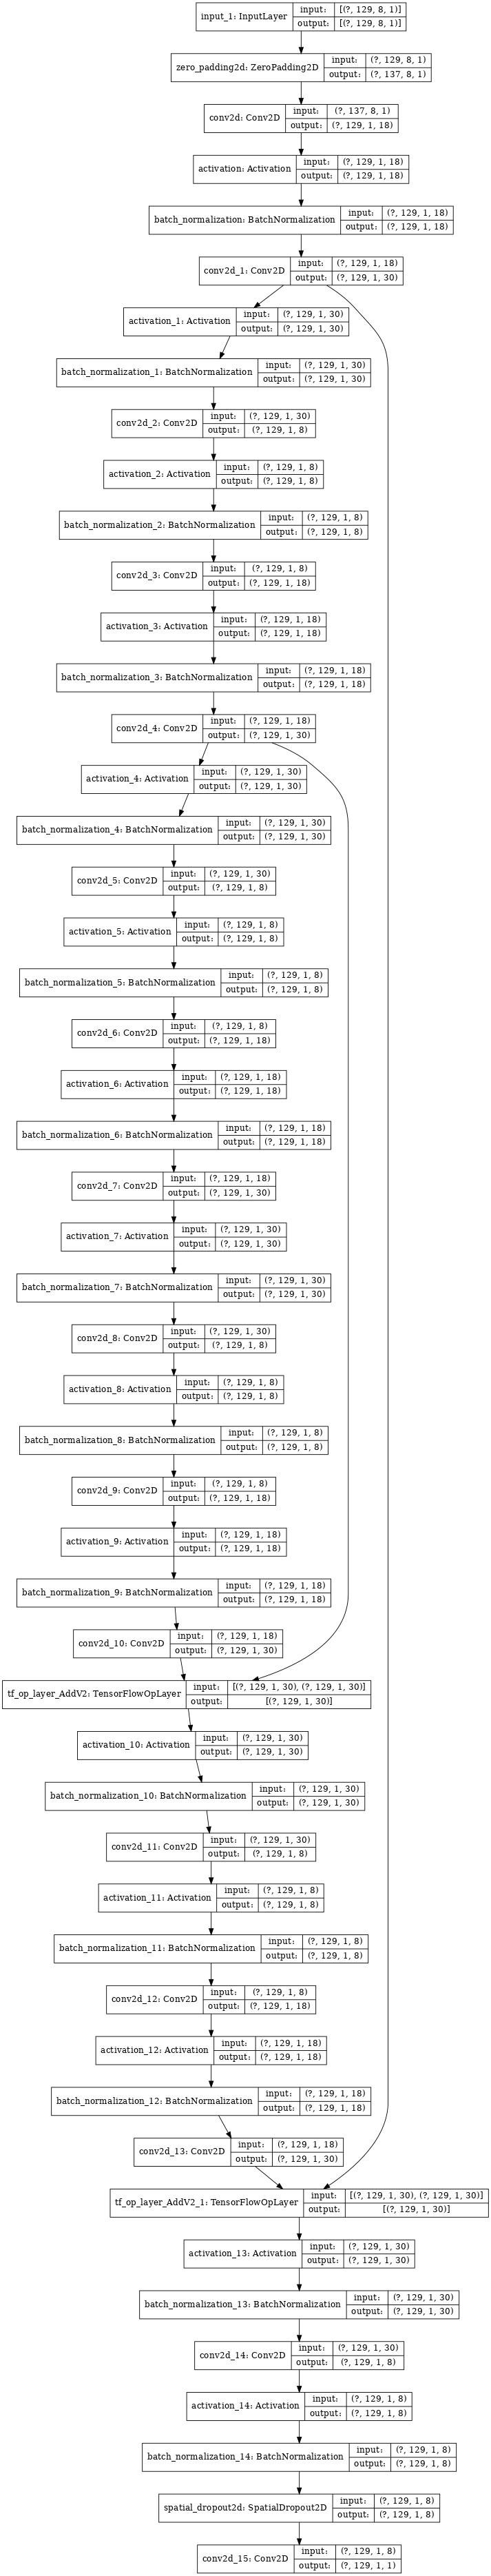

In [18]:
tf.keras.utils.plot_model(model,show_shapes = True,dpi = 64)

In [19]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 25908), started 0:28:37 ago. (Use '!kill 25908' to kill it.)

In [20]:
baseline_val_loss = model.evaluate(test_dataset)[0]
print(f"Baseline accuracy {baseline_val_loss}")

629/629 [==============================] - 16s 26ms/step - loss: 0.5907 - rmse: 0.7686
Baseline accuracy 0.5907480716705322


In [21]:
def l2_norm(vector):
    return np.square(vector)

def SDR(denoised,cleaned,eps = 1e-7):
    a = l2_norm(denoised)
    b = l2_norm(denoised_clean)
    a_b = a / b
    return np.mean(10 * np.log10(a_b + eps))

In [22]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                          patience = 50,
                                                          restore_best_weights = True,
                                                          baseline = None)
logdir = os.path.join("logs",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,update_freq = 'batch')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = './denoiser_cnn_log_mel_generator.h5',
                                                        monitor = 'val_loss',
                                                        save_best_only = True)

model.fit(train_dataset,
         steps_per_epoch = 50,
         validation_data = test_dataset,
         epochs = 50,
         callbacks = [early_stopping_callback,tensorboard_callback,checkpoint_callback])

Epoch 1/50
 1/50 [..............................] - ETA: 0s - loss: 2.9599 - rmse: 1.7204WARNING:tensorflow:From /home/abhish/anaconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
50/50 [==============================] - 17s 336ms/step - loss: 1.4984 - rmse: 1.2241 - val_loss: 0.5648 - val_rmse: 0.7515
Epoch 2/50
50/50 [==============================] - 16s 322ms/step - loss: 0.7260 - rmse: 0.8520 - val_loss: 0.5152 - val_rmse: 0.7178
Epoch 3/50
50/50 [==============================] - 17s 339ms/step - loss: 0.5119 - rmse: 0.7155 - val_loss: 0.4623 - val_rmse: 0.6799
Epoch 4/50
50/50 [==============================] - 16s 329ms/step - loss: 0.5091 - rmse: 0.7135 - val_loss: 0.4040 - val_rmse: 0.6356
Epoch 5/50
50/50 [==============================] - 18s 352ms/step - loss: 0.4453 - 